In [101]:
# Read in goal_shot_rows.csv

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

import data_prep

In [159]:
def create_input_data_from_csv(path_to_csv):
    df = pd.read_csv(path_to_csv)

    print(len(df))
    print("HELLO WORLD 2")
    
    # get list of ilocs of rows where the 'Event' column is 'GOAL or SHOT'
    goal_shot_rows = df.loc[df['Event'].isin(['GOAL', 'SHOT'])]

    print(goal_shot_rows["Event"])

    print(list(goal_shot_rows.columns.values).count("prev_xC"))

    # shift the dataframe by 1 row
    shifted_df = df.shift(1)
    shifted_df.columns = ['prev_' + name for name in df.columns]

    print(list(shifted_df.columns.values).count("prev_xC"))

    # combine goal_shot_rows with shifted_df, but using rows from goal_shot_rows
    goal_shot_rows = pd.concat([goal_shot_rows, shifted_df.loc[goal_shot_rows.index]], axis=1)
    print(list(goal_shot_rows.columns.values).count("prev_xC"))

    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 0]
    goal_shot_rows = goal_shot_rows[goal_shot_rows['Period'] != 5]

    val_input_data = goal_shot_rows[['Event', 'Period', 'Seconds_Elapsed', 'Strength', 'Type', 'xC', 'yC', 'prev_Event', 'prev_Period', 'prev_Seconds_Elapsed', 'prev_Strength', 'prev_Type', 'prev_xC', 'prev_yC']]
    val_result_data = goal_shot_rows['Event']
    val_result_data = val_result_data.apply(lambda x: 1 if x == "GOAL" else 0)

    val_input_data = val_input_data.drop(columns=['Event'])
    print(list(val_input_data.columns.values).count("prev_xC"))

    # Split out the data between numeric values (can carry forward) and categorical values (need to be turned into binary columns)
    val_input_data_numeric = val_input_data[['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed', 'prev_xC', 'prev_yC']]
    val_input_data_categorical = pd.DataFrame()

    for column in ['Strength', 'Type', 'prev_Event']:
        dummy_columns = pd.get_dummies(val_input_data[column])
        val_input_data_categorical = pd.concat([dummy_columns, val_input_data_categorical], axis=1)

    for column in ['prev_Event', 'prev_Strength', 'prev_Type']:
        dummy_columns = pd.get_dummies(val_input_data[column])

        # rename all columns with a prefix of "prev_"
        dummy_columns.columns = ['prev_' + str(col) for col in dummy_columns.columns]
        val_input_data_categorical = pd.concat([val_input_data_categorical, dummy_columns], axis=1)
        
    # change all True/False to 1/0
    val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)

    # combine the two dataframes
    val_input_data_combined = pd.concat([val_input_data_numeric, val_input_data_categorical], axis=1)

    #set val_input_data2 to be all floats
    val_input_data_combined = val_input_data_combined.astype(float)

    columns = ['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed',
            'prev_xC', 'prev_yC', 'BLOCK', 'CHL', 'DELPEN', 'FAC', 'GIVE', 'HIT',
            'MISS', 'PENL', 'SHOT', 'STOP', 'TAKE', 'BACKHAND', 'DEFLECTED',
            'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT', '0x0',
            '3x3', '3x4', '3x5', '4x3', '4x4', '4x5', '5x3', '5x4', '5x5', '6x5',
            'prev_BLOCK', 'prev_CHL', 'prev_DELPEN', 'prev_FAC', 'prev_GIVE',
            'prev_HIT', 'prev_MISS', 'prev_PENL', 'prev_SHOT', 'prev_STOP',
            'prev_TAKE', 'prev_0x5', 'prev_3x3', 'prev_3x4', 'prev_3x5', 'prev_4x3',
            'prev_4x4', 'prev_4x5', 'prev_5x3', 'prev_5x4', 'prev_5x5', 'prev_5x6',
            'prev_BACKHAND', 'prev_DEFLECTED',
            'prev_PS-Covering puck in crease(0 min)',
            'prev_PS-Goalkeeper displaced net(0 min)',
            'prev_PS-Holding on breakaway(0 min)',
            'prev_PS-Hooking on breakaway(0 min)',
            'prev_PS-Slash on breakaway(0 min)',
            'prev_PS-Throw object at puck(0 min)',
            'prev_PS-Tripping on breakaway(0 min)', 'prev_SLAP SHOT',
            'prev_SNAP SHOT', 'prev_TIP-IN', 'prev_WRAP-AROUND', 'prev_WRIST SHOT']

    print(val_input_data_combined.shape)
    print(val_input_data_combined.columns)
    # For each column in input_data_combined, check if it exists in val_input_data_combined, if not add it as all 0s
    for column in columns:
        if column not in val_input_data_combined.columns:
                val_input_data_combined[column] = 0

    for column in val_input_data_combined.columns:
        if column not in columns:
                if column in val_input_data_combined.columns:
                    print(f"Column {column} not in columns")
                    val_input_data_combined = val_input_data_combined.drop(column, axis=1)

    print(val_input_data_combined.shape)
    print(val_input_data_combined.columns)

    # reduce val_input_data_combined to have the same columns as input_data_combined
    val_input_data_combined = val_input_data_combined[columns]

    # change all NaN numbers to 0
    val_input_data_combined = val_input_data_combined.fillna(0)

    print(val_input_data_combined.shape)

    filepath = '0422Model_800k.pt'
    model = nn.Sequential(
        nn.Linear(72, 120),
        nn.ReLU(),
        nn.Linear(120, 60),
        nn.ReLU(),
        nn.Linear(60, 1),
        nn.Sigmoid()
    )

    model.load_state_dict(torch.load(filepath))
    model.eval()
    model.cpu()

    x = torch.tensor(val_input_data_combined.values, dtype=torch.float32)
    y = torch.tensor(val_result_data.values, dtype=torch.float32)
    result = model(x)

    # add the probability of a goal to val_input_data_combined
    goal_shot_rows['Goal_Probability'] = result.detach().numpy()

    return val_input_data_combined, val_result_data, goal_shot_rows

# Model Evaluation


First Up, single game xG creation


In [160]:
val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20232024.csv")


415953
HELLO WORLD 2
6         SHOT
7         SHOT
9         SHOT
16        SHOT
28        SHOT
          ... 
415922    SHOT
415927    SHOT
415937    SHOT
415940    GOAL
415950    SHOT
Name: Event, Length: 80303, dtype: object
0
1
1
1


C:\Users\JoshG\AppData\Local\Temp\ipykernel_8420\3592049424.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(79805, 73)
Index(['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed',
       'prev_xC', 'prev_yC', 'BLOCK', 'CHL', 'DELPEN', 'FAC', 'GIVE', 'HIT',
       'MISS', 'PENL', 'SHOT', 'STOP', 'TAKE', 'BACKHAND', 'DEFLECTED',
       'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT', '0x0',
       '3x3', '3x4', '3x5', '4x3', '4x4', '4x5', '4x6', '5x3', '5x4', '5x5',
       '5x6', '6x5', 'prev_BLOCK', 'prev_CHL', 'prev_DELPEN', 'prev_FAC',
       'prev_GIVE', 'prev_HIT', 'prev_MISS', 'prev_PENL', 'prev_SHOT',
       'prev_STOP', 'prev_TAKE', 'prev_3x3', 'prev_3x4', 'prev_3x5',
       'prev_4x3', 'prev_4x4', 'prev_4x5', 'prev_5x3', 'prev_5x4', 'prev_5x5',
       'prev_5x6', 'prev_BACKHAND', 'prev_DEFLECTED',
       'prev_GY #8 TANEV PS-Hooking on breakaway(0 min)',
       'prev_PS-Covering puck in crease(0 min)',
       'prev_PS-Holding on breakaway(0 min)',
       'prev_PS-Hooking on breakaway(0 min)',
       'prev_PS-Slash on breakaway(0 min)',
       'prev_PS-Throw

In [161]:
filepath = '0422Model_800k.pt'
model = nn.Sequential(
    nn.Linear(72, 120),
    nn.ReLU(),
    nn.Linear(120, 60),
    nn.ReLU(),
    nn.Linear(60, 1),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(filepath))
model.eval()
model.cpu()

x = torch.tensor(val_input_data.values, dtype=torch.float32)
y = torch.tensor(val_result_data.values, dtype=torch.float32)



In [105]:
# get the accuracy of the model
# y_pred = model(x)
# accuracy = (y_pred.round() == y).float().mean()
# print(f"Accuracy {accuracy}")

xC
 82.0     1332
-82.0     1284
-81.0     1255
 81.0     1242
-80.0     1166
          ... 
-98.0       20
 98.0       19
 99.0       13
-99.0       10
 100.0       4
Name: count, Length: 200, dtype: int64


<Axes: xlabel='Strength', ylabel='Goal_Probability'>

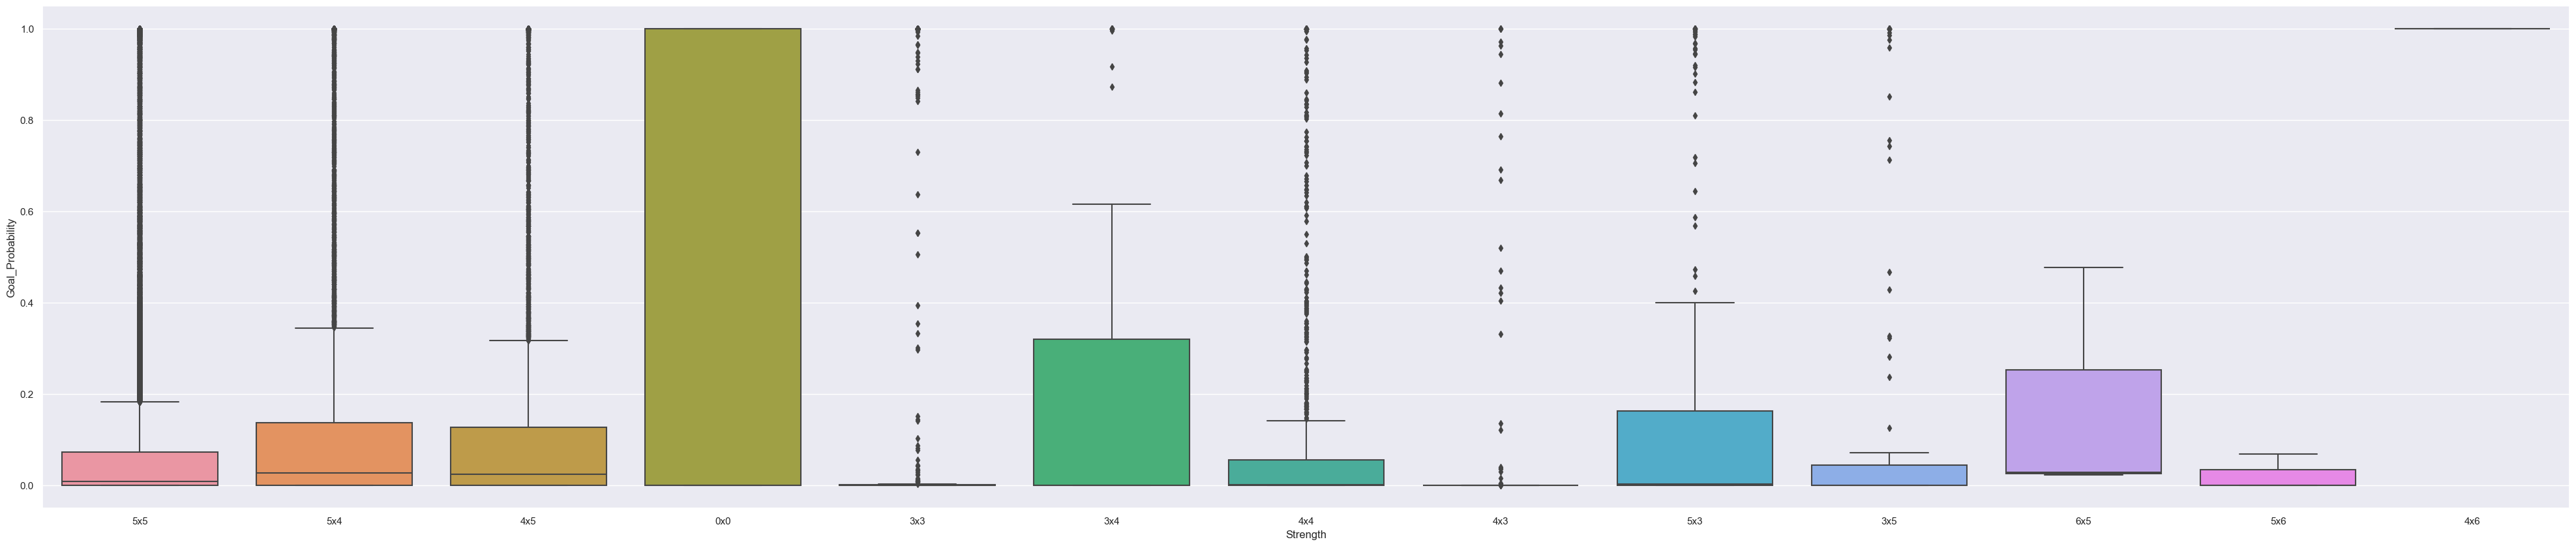

In [162]:
result = model(x)

# add the probability of a goal to val_input_data_combined
original_input['Goal_Probability'] = result.detach().numpy()

# print the values of val_input_data["Type"]
print(original_input["xC"].value_counts())

# make a boxplot of Goal_Probability vs Type
sns.set_theme(rc={'figure.figsize':(50,10)})
sns.boxplot(x=original_input["Strength"], y=original_input["Goal_Probability"])
# sns.scatterplot(x=original_input["Type"], y=original_input["Goal_Probability"])


# Single Game 5v5 evaluation



In [168]:
def single_game_evaluation(original_input, game_id, state = "any"):
    game_rows = original_input[original_input["Game_Id"] == game_id]

    if state != "any":
        game_rows = game_rows[game_rows["Strength"] == state]

    # get first value of Home_Team and Away_Team
    home_team = game_rows["Home_Team"].iloc[0]
    away_team = game_rows["Away_Team"].iloc[0]

    # get all rows where the Ev_Team is the home team
    home_team_rows = game_rows[game_rows["Ev_Team"] == home_team]

    # get all rows where the Ev_Team is the away team
    away_team_rows = game_rows[game_rows["Ev_Team"] == away_team]

    # add a new column "total_xG" to home_team_rows and away_team_rows
    home_team_rows["total_xG"] = home_team_rows["Goal_Probability"].cumsum()
    away_team_rows["total_xG"] = away_team_rows["Goal_Probability"].cumsum()

    # time elapsed is (period - 1) * 1200 + seconds_elapsed
    home_team_rows["Seconds_Elapsed"] = (home_team_rows["Period"] - 1) * 1200 + home_team_rows["Seconds_Elapsed"]
    home_team_rows["Minutes_Elapsed"] = home_team_rows["Seconds_Elapsed"] / 60

    # print home_team_rows to csv
    home_team_rows.to_csv("home_team_rows.csv")

    # time elapsed is (period - 1) * 1200 + seconds_elapsed
    away_team_rows["Seconds_Elapsed"] = (away_team_rows["Period"] - 1) * 1200 + away_team_rows["Seconds_Elapsed"]
    away_team_rows["Minutes_Elapsed"] = away_team_rows["Seconds_Elapsed"] / 60

    away_team_rows.to_csv("away_team_rows.csv")

    total_home_xG = home_team_rows["total_xG"].iloc[-1].round(2)
    total_away_xG = away_team_rows["total_xG"].iloc[-1].round(2)

    # combine home_team_rows and away_team_rows into one dataframe
    combined_rows = pd.concat([home_team_rows, away_team_rows])

    home_score = home_team_rows["Home_Score"].iloc[-1]
    away_score = away_team_rows["Away_Score"].iloc[-1]

    return combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score


432
HELLO WORLD 2
10     SHOT
11     SHOT
16     SHOT
18     SHOT
24     SHOT
       ... 
403    SHOT
409    SHOT
410    SHOT
411    SHOT
427    GOAL
Name: Event, Length: 64, dtype: object
0
1
1
1
(64, 43)
Index(['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed',
       'prev_xC', 'prev_yC', 'BLOCK', 'DELPEN', 'FAC', 'GIVE', 'HIT', 'MISS',
       'SHOT', 'TAKE', 'BACKHAND', 'DEFLECTED', 'SLAP SHOT', 'SNAP SHOT',
       'TIP-IN', 'WRIST SHOT', '4x4', '4x5', '5x4', '5x5', 'prev_BLOCK',
       'prev_DELPEN', 'prev_FAC', 'prev_GIVE', 'prev_HIT', 'prev_MISS',
       'prev_SHOT', 'prev_TAKE', 'prev_4x4', 'prev_4x5', 'prev_5x4',
       'prev_5x5', 'prev_BACKHAND', 'prev_DEFLECTED', 'prev_SLAP SHOT',
       'prev_SNAP SHOT', 'prev_TIP-IN', 'prev_WRIST SHOT'],
      dtype='object')
(64, 72)
Index(['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed',
       'prev_xC', 'prev_yC', 'BLOCK', 'DELPEN', 'FAC', 'GIVE', 'HIT', 'MISS',
       'SHOT', 'TAKE', 'BACKHAND', 'DEFLECT

C:\Users\JoshG\AppData\Local\Temp\ipykernel_8420\3592049424.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)
C:\Users\JoshG\AppData\Local\Temp\ipykernel_8420\2470549698.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_team_rows["total_xG"] = home_team_rows["Goal_Probability"].cumsum()
C:\Users\JoshG\AppData\Local\Temp\ipykernel_8420\2470549698.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

<Axes: title={'center': 'TOR (4.00) vs BOS (0.88)'}, xlabel='Minutes_Elapsed', ylabel='total_xG'>

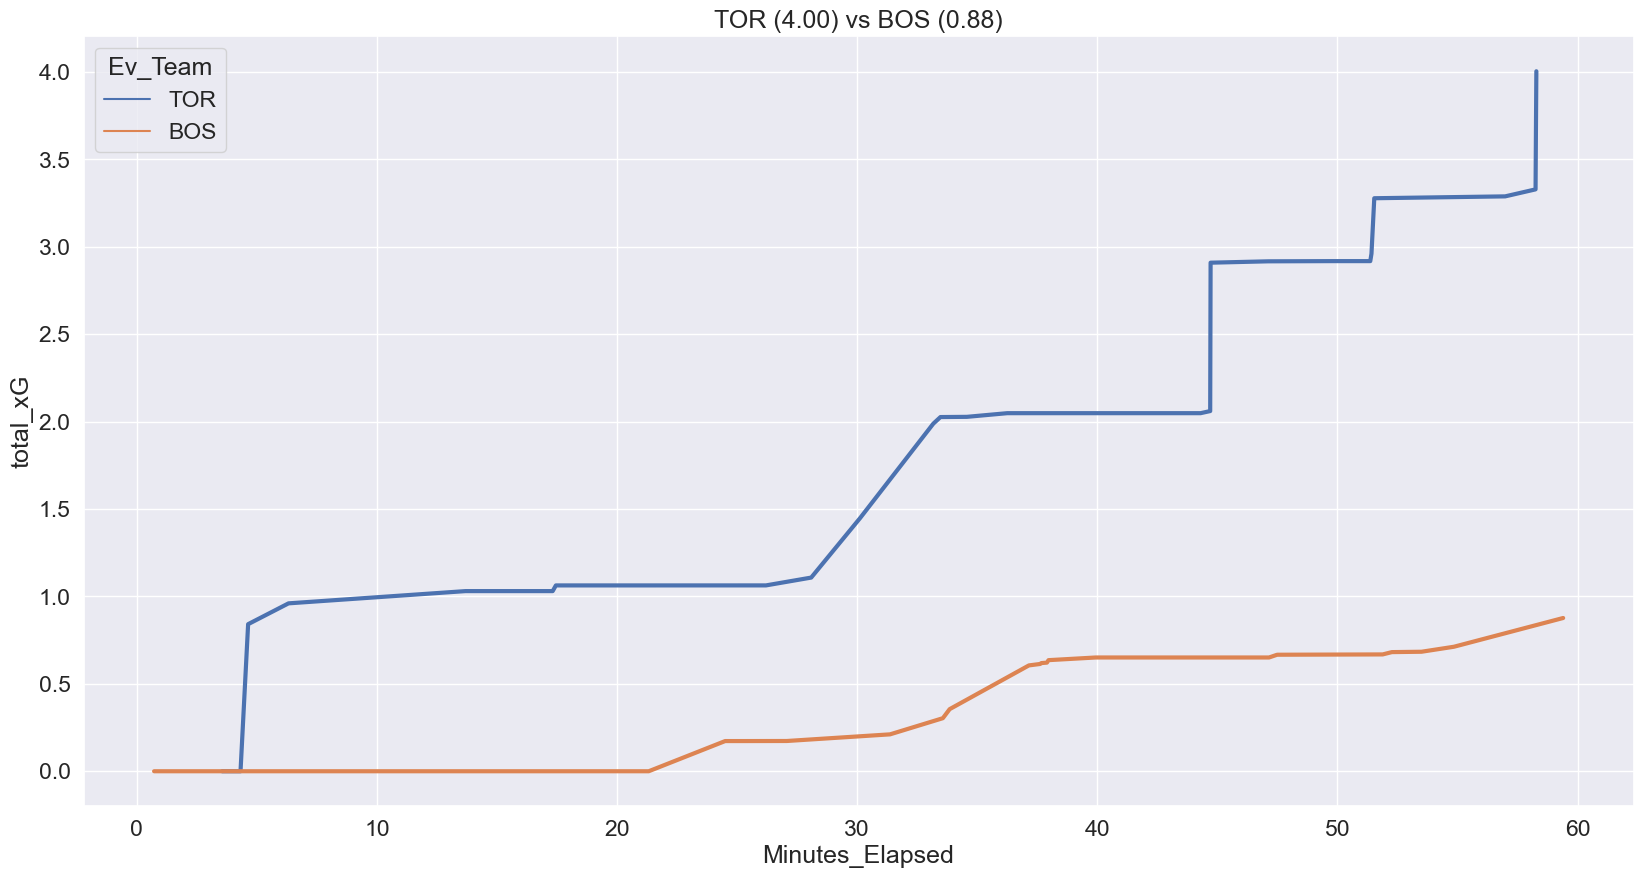

In [157]:
game_id = 30123

val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_1714030348.csv")


combined_rows, home_team, total_home_xG, away_team, total_away_xG = single_game_evaluation(original_input, game_id, "any")

# print combined rows to csv
combined_rows.to_csv("combined_rows.csv")

# plot the total_xG of the home team
float_formatter = "{:.2f}".format
sns.set_theme(rc={'figure.figsize':(20,10)})
sns.set_theme(style="darkgrid", font='Arial', font_scale=1.5, color_codes=True, rc=None)
# set title to [home_team] vs [away_team]
plt.title(f"{home_team} ({float_formatter(total_home_xG)}) vs {away_team} ({float_formatter(total_away_xG)})")
sns.lineplot(data=combined_rows, x="Minutes_Elapsed", y="total_xG", hue="Ev_Team", linewidth = 3)


# Full Season Rolling Evaluation

Rough idea is as follows:

- For the first 20 games of each team's season, just tally the team's XG% (all situations)
- From then on out (assuming both teams have 20 games), take the avg xG% of each teams last 20 games, then compare/normalize to 100%. Figure out who the winner was, and mark that as a correct prediction, or a failure.

In [179]:
# read in nhl_pbp_20232024.csv
val_input_data, val_result_data, original_input = create_input_data_from_csv(r"C:\Users\JoshG\hockey_scraper_data\csvs\nhl_pbp_20232024.csv")

# split original_input into multiple dataframes based off of game_id
game_ids = original_input["Game_Id"].unique()
# remove all instances of game_ids that start with 3
game_ids = [x for x in game_ids if str(x)[0] != "3"]

nhl_teams = {}

results = []
predictions = []
predictions_rounded = []

for game_id in game_ids:
    # print(f"Game ID: {game_id}")
    combined_rows, home_team, total_home_xG, away_team, total_away_xG, home_score, away_score = single_game_evaluation(original_input, game_id, "any")

    # add the total_xG of the home team and away team to nhl_teams
    if home_team not in nhl_teams:
        nhl_teams[home_team] = {"xG_percent": [], "total_games": 0}
    if away_team not in nhl_teams:
        nhl_teams[away_team] = {"xG_percent": [], "total_games": 0}

    # if both teams have more than 20 games played, create a prediciton for the game
    if nhl_teams[home_team]["total_games"] >= 20 and nhl_teams[away_team]["total_games"] >= 20:
        # get the average of last 20 games for home_team and away_team
        home_xG_percent_avg = np.mean(nhl_teams[home_team]["xG_percent"][-20:])
        away_xG_percent_avg = np.mean(nhl_teams[away_team]["xG_percent"][-20:])
        # print(f"{home_team} xG%: {home_xG_percent_avg} {away_team} xG%: {away_xG_percent_avg}")

        # normalize home_xG_percent_avg and away_xG_percent_avg
        home_xG_percent_avg = home_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)
        away_xG_percent_avg = away_xG_percent_avg / (home_xG_percent_avg + away_xG_percent_avg)

        results.append(home_score > away_score)
        predictions.append(home_xG_percent_avg)
        predictions_rounded.append(home_xG_percent_avg.round())

    home_xG_percent = total_home_xG / (total_home_xG + total_away_xG)
    away_xG_percent = total_away_xG / (total_home_xG + total_away_xG)

    nhl_teams[home_team]["xG_percent"].append(home_xG_percent)
    nhl_teams[away_team]["xG_percent"].append(away_xG_percent)
    nhl_teams[home_team]["total_games"] += 1
    nhl_teams[away_team]["total_games"] += 1





415953
HELLO WORLD 2
6         SHOT
7         SHOT
9         SHOT
16        SHOT
28        SHOT
          ... 
415922    SHOT
415927    SHOT
415937    SHOT
415940    GOAL
415950    SHOT
Name: Event, Length: 80303, dtype: object
0
1
1
1


C:\Users\JoshG\AppData\Local\Temp\ipykernel_8420\3592049424.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  val_input_data_categorical = val_input_data_categorical.applymap(lambda x: 1 if x == True else 0)


(79805, 73)
Index(['Period', 'Seconds_Elapsed', 'xC', 'yC', 'prev_Seconds_Elapsed',
       'prev_xC', 'prev_yC', 'BLOCK', 'CHL', 'DELPEN', 'FAC', 'GIVE', 'HIT',
       'MISS', 'PENL', 'SHOT', 'STOP', 'TAKE', 'BACKHAND', 'DEFLECTED',
       'SLAP SHOT', 'SNAP SHOT', 'TIP-IN', 'WRAP-AROUND', 'WRIST SHOT', '0x0',
       '3x3', '3x4', '3x5', '4x3', '4x4', '4x5', '4x6', '5x3', '5x4', '5x5',
       '5x6', '6x5', 'prev_BLOCK', 'prev_CHL', 'prev_DELPEN', 'prev_FAC',
       'prev_GIVE', 'prev_HIT', 'prev_MISS', 'prev_PENL', 'prev_SHOT',
       'prev_STOP', 'prev_TAKE', 'prev_3x3', 'prev_3x4', 'prev_3x5',
       'prev_4x3', 'prev_4x4', 'prev_4x5', 'prev_5x3', 'prev_5x4', 'prev_5x5',
       'prev_5x6', 'prev_BACKHAND', 'prev_DEFLECTED',
       'prev_GY #8 TANEV PS-Hooking on breakaway(0 min)',
       'prev_PS-Covering puck in crease(0 min)',
       'prev_PS-Holding on breakaway(0 min)',
       'prev_PS-Hooking on breakaway(0 min)',
       'prev_PS-Slash on breakaway(0 min)',
       'prev_PS-Throw

C:\Users\JoshG\AppData\Local\Temp\ipykernel_8420\1588310819.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_team_rows["total_xG"] = home_team_rows["Goal_Probability"].cumsum()
C:\Users\JoshG\AppData\Local\Temp\ipykernel_8420\1588310819.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_team_rows["total_xG"] = away_team_rows["Goal_Probability"].cumsum()
C:\Users\JoshG\AppData\Local\Temp\ipykernel_8420\1588310819.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [180]:
# get the accuracy of the model
results_tensor = torch.tensor(results, dtype=torch.float32)
predictions_tensor = torch.tensor(predictions, dtype=torch.float32)
predictions_rounded_tensor = torch.tensor(predictions_rounded, dtype=torch.float32)

accuracy = (predictions_rounded_tensor == results_tensor).float().mean()

# calculate log loss of predicitons
log_loss = nn.BCELoss()
log_loss_results = log_loss(predictions_tensor, results_tensor)

print(f"Accuracy {accuracy}")
print(f"log loss {log_loss_results}")

Accuracy 0.5637105107307434
log loss 0.6798285841941833


In [189]:
# for each team in nhl_teams, get the avg xG% over the last 20 games played and sort
team_xG_percent = {}
for team in nhl_teams:
    if nhl_teams[team]["total_games"] >= 20:
        team_xG_percent[team] = np.mean(nhl_teams[team]["xG_percent"][-20:])
    else:
        team_xG_percent[team] = 0

sorted_team_xG_percent = dict(sorted(team_xG_percent.items(), key=lambda item: item[1], reverse=True))

for key, value in sorted_team_xG_percent.items():
    print(f'{key}:  {value}')


CAR:  0.6069251298904419
DAL:  0.5784175992012024
EDM:  0.577721118927002
MIN:  0.5746570229530334
COL:  0.5608959197998047
FLA:  0.5586969256401062
NSH:  0.5496378540992737
VGK:  0.5421119332313538
VAN:  0.5396530628204346
PHI:  0.5364879369735718
NYR:  0.5349913835525513
PIT:  0.5338390469551086
CGY:  0.5324481725692749
OTT:  0.5289131999015808
NYI:  0.5267432332038879
DET:  0.5130178928375244
L.A:  0.5094839334487915
ARI:  0.5055967569351196
T.B:  0.4929996430873871
BUF:  0.48320525884628296
STL:  0.4814545214176178
TOR:  0.47720417380332947
BOS:  0.47050151228904724
SEA:  0.46452030539512634
N.J:  0.45123061537742615
ANA:  0.44797855615615845
WPG:  0.4450574517250061
CBJ:  0.43609732389450073
CHI:  0.4294067919254303
MTL:  0.4201723635196686
WSH:  0.37151214480400085
S.J:  0.32649660110473633
